In [48]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import pandas as pd
from scipy import interpolate
import functions as func

In [10]:
isoch_files=['iso0.txt']

def read_isochrones(isoch_files):

    isochrones={}
    AGE=[]
    METALLICITY=[]

    for file_name in isoch_files:
        isoch_table=[]
        mylines = []                             # Declare an empty list named mylines.
        with open (file_name, 'rt') as myfile: # Open lorem.txt for reading text data.
            for myline in myfile:                # For each line, stored as myline,
                mylines.append(myline)           # add its contents to mylines.  
        #print(len(mylines))
        for i in range(len(mylines)):
            if mylines[i][0] == '#':
                continue
            isoch=mylines[i].split()
            for j in range(len(isoch)):
                isoch[j]=float(isoch[j])
            isoch_table.append(isoch) 
        #print(mylines[13].split()[1:])
        stellarpop=pd.DataFrame(isoch_table,columns=mylines[13].split()[1:])
        stellarpop=stellarpop[stellarpop['label']!=9]  # drop Post AGB points because those mess with star generation!
        logage=np.sort(stellarpop['logAge'].value_counts().index.tolist())
        MHs = np.sort(stellarpop['MH'].value_counts().index.tolist())
        #print(logage,MHs)
        AGE.append(logage)
        METALLICITY.append(MHs)
        for age in logage:
            for metallicity in MHs:
                isochrones[f'logAge:{age:.2f}_MH:{metallicity:.2f}']=[[age,metallicity],stellarpop[(stellarpop['logAge']==age) & (stellarpop['MH']==metallicity)]]
    parsec=[]
    return (isochrones)
#isochrone_names=list(isochrones.keys())


In [36]:
def IMF_Kroupa(mass_lower_bound, 
                mass_upper_bound, 
                n_mass_grid=1000000, 
                alpha = [.3,1.3,2.3]):

    """Initial mass function

    Calculate the Kroupa IMF.

    Args:
        masses (array): numpy vector. An array of mass between the min and max masses.
        alpha (list): A list with three elements which are the Kroupa IMF slopes.

    Returns:
        array: An array
    """
    #mass_min = np.min(isochrone[1]['Mini'])
    #mass_max= np.max(isochrone[1]['Mini'])
    mass_min = mass_lower_bound
    mass_max = mass_upper_bound
    mass_grid = np.linspace(mass_min,mass_max, n_mass_grid) # create the mass grid    
    IMF = np.zeros(n_mass_grid, dtype = float)
    dy1 = (np.power(.5,-alpha[2])-np.power(.5,-alpha[1]))
    dy2 = dy1+(np.power(.08,-alpha[1])-np.power(.08,-alpha[0]))
    for i,mass in enumerate(mass_grid):
        #print(i,mass,alpha[1],IMF[i],np.power(mass,-alpha[0]))
        if         mass <= .08 : IMF[i]=np.power(mass,-alpha[0])+dy2
        elif .08 < mass <= .5  : IMF[i]=np.power(mass,-alpha[1])+dy1
        else                   : IMF[i]=np.power(mass,-alpha[2])
    #print(np.power(.5,-alpha[2]) )       
    IMF = IMF/np.sum(IMF)
    return mass_grid , IMF

In [42]:

def stellar_mass_generator(n_stars, mass_grid, IMF):

    generated_masses=np.random.choice(mass_grid, size=n_stars, replace=True, p=IMF) # generate new masses

    return(generated_masses)


In [43]:
mass_grid , IMF = IMF_Kroupa(mass_lower_bound = .01, 
                        mass_upper_bound = 5, 
                        n_mass_grid=1000000, 
                        alpha = [.3,1.3,2.3])


In [74]:
def SSP_generator(isochrone_table, 
                    bands, 
                    n_stars, 
                    distandmodulus = 0,
                    uncertainty = True,
                    absolute_mag_features = np.array([4 , 5]),
                    SN_feature = [10,10],
                    uncertainty_param = [[-23.85588548 , 0.7982657 ], [-24.53558396 , 0.84130151]],
                    plot = True): 
    # Input isochrone_table should be a dataframe.
    # Input n_star is the number of generated stars.
    mass_lower_bound = np.min(isochrone_table[1]['Mini'])
    mass_upper_bound= np.max(isochrone_table[1]['Mini'])
    
    #IMF = IMF_Kroupa(mass_lower_bound = mass_lower_bound, mass_upper_bound = mass_upper_bound)
    mass_grid , IMF = IMF_Kroupa(mass_lower_bound = mass_lower_bound, 
                                    mass_upper_bound = mass_upper_bound, 
                                    n_mass_grid=1000000, 
                                    alpha = [.3,1.3,2.3])
    
    #new_masses=random.choices(mass_bin, weights=IMF, k=n_stars) # generate new masses
    #new_masses=np.random.choice(mass_bin, weights=IMF, k=n_stars) # generate new masses
    new_masses = stellar_mass_generator(n_stars, mass_grid , IMF) # generate new masses


    SSP = pd.DataFrame(new_masses , columns=['Mini'])           # make a df for the SSP

    logAge = isochrone_table[0][0]
    SSP['logAge']= np.full(n_stars,logAge)

    MH = isochrone_table[0][1]
    SSP['MH']= np.full(n_stars,MH)
    
    for band in bands:
        x = isochrone_table[1]['Mini']
        y = isochrone_table[1][band]
        f = interpolate.interp1d(x, y)
        #globals()[' %s' % band] = f(new_masses) 
        SSP[band] = f(new_masses)  # estimate the mags for the generated masses and add to the SSP

        SSP[band] += distandmodulus
    


    distandmodulus = 24
    #print('distandmodulus= ', distandmodulus)
    mag_feature = absolute_mag_features + distandmodulus
    SN_feature = [10,10]
    #print('mag_feature=', mag_feature)

    bands_unc_coef=[[-23.85588548 , 0.7982657 ], [-24.53558396 , 0.84130151]]  #IC1613

    colour_min = -1
    colour_max = 4

    magnitude_max = mag_feature
    magnitude_min = magnitude_max - 10

    if uncertainty == True:
        for b,band in enumerate(bands):
            SSP[band] = SSP[band][( SSP[bands[1]] < magnitude_max[1]+1.193 )]
            SSP[band] = add_uncerntaties(SSP[band],fit_param = uncertainty_param[b], mag_feature = mag_feature[b], SN_feature = SN_feature[b])[0]
            SSP[band] = SSP[band][( SSP[bands[1]] < magnitude_max[1]+1.193 )]



    if plot == True:
        a = SSP[bands[0]]
        b = SSP[bands[1]]

        x = a-b
        y = b

        #plt.scatter(x,y,s=10,c=SSP['Mini'])
        plt.scatter(x,y,s=1)
        #plt.scatter(stellarpop.F555Wmag-stellarpop.F814Wmag,stellarpop.F814Wmag,c=stellarpop.Mass,s=5, cmap='cool') #,label='logAGE=%.2f'%(logAGE)
        plt.gca().invert_yaxis()
        plt.xlabel(f'{bands[0]}-{bands[1]}')  #don't forget chanfe the axis title if you chose different bands!
        pl.rcParams["figure.figsize"] = (8,8)
        #plt.xlim(colour_min,2)
        #print(magnitude_max[1],magnitude_min[0])
        #plt.ylim(magnitude_max[1],magnitude_min[0])
        plt.ylabel(f'{bands[1]}')
        plt.legend()
        plt.show()
    return SSP

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


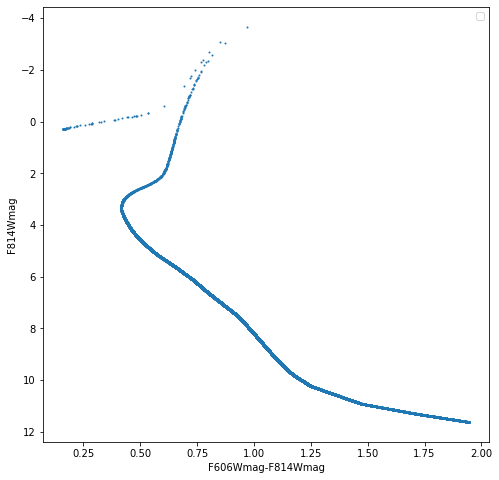

In [77]:
isoch_files=['iso0.txt']
isochrones = read_isochrones(isoch_files)
bands=['F606Wmag','F814Wmag']

SSP = SSP_generator(isochrones[isochrone_names[0]], bands=bands, n_stars = 100000,uncertainty = True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


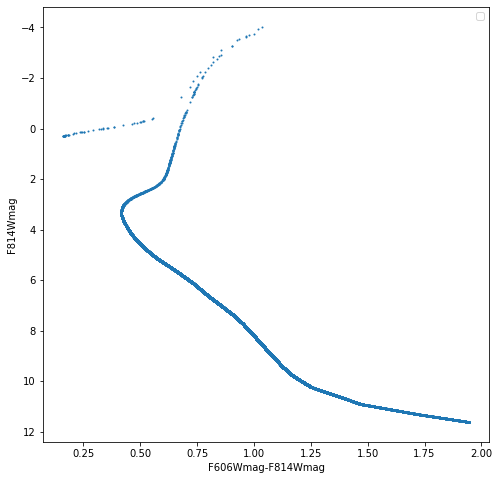

In [73]:
a = SSP[bands[0]]
b = SSP[bands[1]]

x = a-b
y = b

#plt.scatter(x,y,s=10,c=SSP['Mini'])
plt.scatter(x,y,s=1)
#plt.scatter(stellarpop.F555Wmag-stellarpop.F814Wmag,stellarpop.F814Wmag,c=stellarpop.Mass,s=5, cmap='cool') #,label='logAGE=%.2f'%(logAGE)
plt.gca().invert_yaxis()
plt.xlabel(f'{bands[0]}-{bands[1]}')  #don't forget chanfe the axis title if you chose different bands!
pl.rcParams["figure.figsize"] = (8,8)
#plt.xlim(colour_min,2)
#print(magnitude_max[1],magnitude_min[0])
#plt.ylim(magnitude_max[1],magnitude_min[0])
plt.ylabel(f'{bands[1]}')
plt.legend()
plt.show()

In [64]:
def add_uncerntaties(magnitudes,
                        fit_param, 
                        mag_feature, 
                        SN_feature):
    
    # INPUT: 
    
    # magnitudes: magnitudes of simulated sources
    # fit param: best fit parameters found by fiting delra_m=exp(a+b*m) where m and delta_m are the magnitudes and magnitude uncertanties of the reference data for uncertainties!
    # mag_feature: This is the apparant magnitude of your desired feature which you want to have the S/N ratio of SN_feature
    # SN_feature: SN_feature for mag_feature
    
    #######################################
    
    # OUTPUT: 
    
    # mag_with_unc: Input magnitudes + randon gaussian uncertainties
    # delta_m_final: Sigma of random gaussian uncertainties
    # exp_time_final: The ratio of needed exposure time to the exposure time of the reference data to get to SN_feature for mag_feature
    
    Xn = np.c_[np.ones(magnitudes.size), magnitudes]
    delta_m_initial = poisonModel_Prediction_unc(fit_param, Xn)
    delta_m_feature_initial = poisonModel_Prediction_unc(fit_param, np.c_[np.ones(1), mag_feature])
    
    SN_feature_initial = 1/(10**(-.4*(-delta_m_feature_initial))-1)
    exp_time_initial = 1
    exp_time_final = exp_time_initial*(SN_feature/SN_feature_initial)**2
    delta_m_final = np.abs(-2.5*np.log10(1 + ( (exp_time_initial/exp_time_final)**.5*(10**(-.4*-delta_m_initial)-1) ) ))
    mag_with_unc = np.random.normal(magnitudes, delta_m_final, magnitudes.shape[0])
    return mag_with_unc,delta_m_final,exp_time_final

def poisonModel_Prediction_unc(b,X):
    yhat = np.exp(X @ b)
    return yhat

In [16]:
bands=['F606Wmag','F814Wmag']
SSP = SSP_generator(isochrones[isochrone_names[0]], bands, n_stars=10000 )#print(SSP.head())

NameError: name 'IMF_Kroupa' is not defined

In [13]:
SSP

NameError: name 'SSP' is not defined